<a href="https://colab.research.google.com/github/ykhuay/ML-Adult-Dataset/blob/main/CSCI218_Group_Project_(ML_on_Adult_Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
This is the Adult (a.k.a "Census Income") dataset. Each entry contains details of a person, such as age, education, job, income and more.

#Description



* **age**:	Age of the individual

* **workclass**:	Type of employer (e.g., Private, Self-emp, Gov)

* **fnlwgt**:	Census weight for population representation

* **education**:	Highest level of education attained (e.g., Bachelors, HS-grad)

* **education-num**:	Education level as a numeric code (e.g., Bachelors → 13)

* **marital-status**:	Marital status (e.g., Married, Single, Divorced)

* **occupation**:	Job type (e.g., Tech-support, Sales, Craft-repair)

* **relationship**:	Relationship to household head (e.g., Husband, Not-in-family)

* **race**:	Race of the individual

* **sex**:	Gender of the individual

* **capital-gain**:	Capital gains earned

* **capital-loss**:	Capital losses incurred

* **hours-per-week**:	Average hours worked per week

* **native-country**:	Country of origin (e.g., United-States, Mexico)

* **income**:	Target variable (<=50K or >50K)


#Goal:
Our goal is to predict whether annual income of an individual exceeds $50K/yr based on census data. We will be using three models, tuning their hyperparameters and pick the best of them.

These three models are:



1. Logistic Regression (LR)

2. Multilayer Perceptron (MLP)

3. Support Vector Machine (SVM).





In [84]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from timeit import default_timer as timer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve,
    precision_recall_curve, roc_auc_score, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from google.colab import drive

# Mount google drive
drive.mount('/content/drive')

# Change file path to read both adult.data and adult.test
train_file = "/content/drive/MyDrive/CSCI218/adult/adult.data"
test_file = "/content/drive/MyDrive/CSCI218/adult/adult.test"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The adult.zip file downloaded from https://archive.ics.uci.edu/dataset/2/adult has **already split the full dataset into train and test set**, which are adult.data and adult.test respectively.

The train set contains 2/3 of the original data and the test set contains the remainder of it.

However, they both contain **missing values**, so our plan is to concatenate both train and test set to have the full dataset (since the zip folder does not contain the file with the full dataset), pre-process it then split it into train and test set again.

This makes it easier to adjust how much of the dataset we want to split and not have to repeat the process for the given train and test set.

In [40]:
# 1. Data Loading
labels = [
        "age", "workclass", "fnlwgt", "education", "education-num",
        "marital-status", "occupation", "relationship", "race",
        "sex", "capital-gain", "capital-loss", "hours-per-week",
        "native-country", "income"
        ]

# load both train and test sets into train_df and test_df respectively
train_df = pd.read_csv(train_file, names=labels, skipinitialspace=True)
test_df  = pd.read_csv(test_file,  names=labels, skiprows=1, skipinitialspace=True)

# concatenate both train and test set to get full dataset
df = pd.concat([train_df, test_df], axis=0)
df = pd.concat([train_df, test_df], axis=0)

# Reset index (to avoid duplicate indexes)
df = df.reset_index(drop=True)

# simple exploration to understand the data
print(f"Shape of Dataset: {df.shape}")
print(f"Shape of Train Set: {train_df.shape}")
print(f"Shape of Test Set: {test_df.shape}\n")

# print dataset info
print("- Dataset Info")
df.info()

# find null values in each column
print("\nChecking for null values")
df.isnull().sum()

Shape of Dataset: (48842, 15)
Shape of Train Set: (32561, 15)
Shape of Test Set: (16281, 15)

- Dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory

,0
age,0
workclass,0
fnlwgt,0
education,0
education-num,0
marital-status,0
occupation,0
relationship,0
race,0
sex,0


In [41]:
# print dataset head
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [42]:
# print dataset tail
df.tail()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.
48841,35,Self-emp-inc,182148,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,United-States,>50K.


From this, we find that there are no null values. However, the website says that there are missing values from **workclass**, **occupation** and **native-country**.

From looking at the last 5 rows of the dataset, we can see that there are **"?"** values in it, presumably a placeholder for missing values.

We will convert the "?" values into their column's mode value.

There are also more steps we can take to make the data cleaner:


*   Remove trailing '.' from values in income column
*   Group native-country by regions (to reduce dimensionality)




In [43]:
# convert "?" values in df to NaN
df[df == '?'] = np.nan

# check how many "?" values got converted to NaN in each column
# also to confirm that only those 3 columns contain missing values
df.isnull().sum()

,0
age,0
workclass,2799
fnlwgt,0
education,0
education-num,0
marital-status,0
occupation,2809
relationship,0
race,0
sex,0


In [44]:
# convert NaN values to mode value of their column (categorical)
cols_to_change = ['workclass', 'occupation', 'native-country']
for col in cols_to_change:
  if col in df.columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# remove trailing '.' from values in income column
df["income"] = df["income"].str.strip(".")

# We have too many countries in native-countries
# Group them into regions
country_mapping = {
    'United-States': 'North America',
    'Cambodia': 'Asia',
    'England': 'Europe',
    'Puerto-Rico': 'North America',
    'Canada': 'North America',
    'Germany': 'Europe',
    'Outlying-US(Guam-USVI-etc)': 'North America',
    'India': 'Asia',
    'Japan': 'Asia',
    'Greece': 'Europe',
    'South': 'Other',
    'China': 'Asia',
    'Cuba': 'South America',
    'Iran': 'Asia',
    'Honduras': 'North America',
    'Philippines': 'Asia',
    'Italy': 'Europe',
    'Poland': 'Europe',
    'Jamaica': 'North America',
    'Vietnam': 'Asia',
    'Mexico': 'North America',
    'Portugal': 'Europe',
    'Ireland': 'Europe',
    'France': 'Europe',
    'Dominican-Republic': 'North America',
    'Laos': 'Asia',
    'Ecuador': 'South America',
    'Taiwan': 'Asia',
    'Haiti': 'North America',
    'Columbia': 'South America',
    'Hungary': 'Europe',
    'Guatemala': 'North America',
    'Nicaragua': 'North America',
    'Scotland': 'Europe',
    'Thailand': 'Asia',
    'Yugoslavia': 'Europe',
    'El-Salvador': 'North America',
    'Trinadad&Tobago': 'North America',
    'Peru': 'South America',
    'Hong': 'Asia',  # Assuming Hong refers to Hong Kong
    'Holand-Netherlands': 'Europe'
}

# Map the 'native-country' column to a new 'region' column
if 'native-country' in df.columns:
  df['region'] = df['native-country'].map(country_mapping).fillna('Other')

# Drop "native-country" column
if 'native-country' in df.columns:
  df = df.drop(columns=['native-country'])

# Check the updated DataFrame
df.tail()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,income,region
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,<=50K,North America
48838,64,Private,321403,HS-grad,9,Widowed,Prof-specialty,Other-relative,Black,Male,0,0,40,<=50K,North America
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,<=50K,North America
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,<=50K,North America
48841,35,Self-emp-inc,182148,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,>50K,North America


Dataset looks cleaner now and is ready to be visualised for EDA.

EDA

- Descriptive Statistics (Numeric):
             age       fnlwgt  education-num  capital-gain  capital-loss  \
count  48842.000    48842.000      48842.000     48842.000     48842.000   
mean      38.644   189664.135         10.078      1079.068        87.502   
std       13.711   105604.025          2.571      7452.019       403.005   
min       17.000    12285.000          1.000         0.000         0.000   
25%       28.000   117550.500          9.000         0.000         0.000   
50%       37.000   178144.500         10.000         0.000         0.000   
75%       48.000   237642.000         12.000         0.000         0.000   
max       90.000  1490400.000         16.000     99999.000      4356.000   

       hours-per-week  
count       48842.000  
mean           40.422  
std            12.391  
min             1.000  
25%            40.000  
50%            40.000  
75%            45.000  
max            99.000  


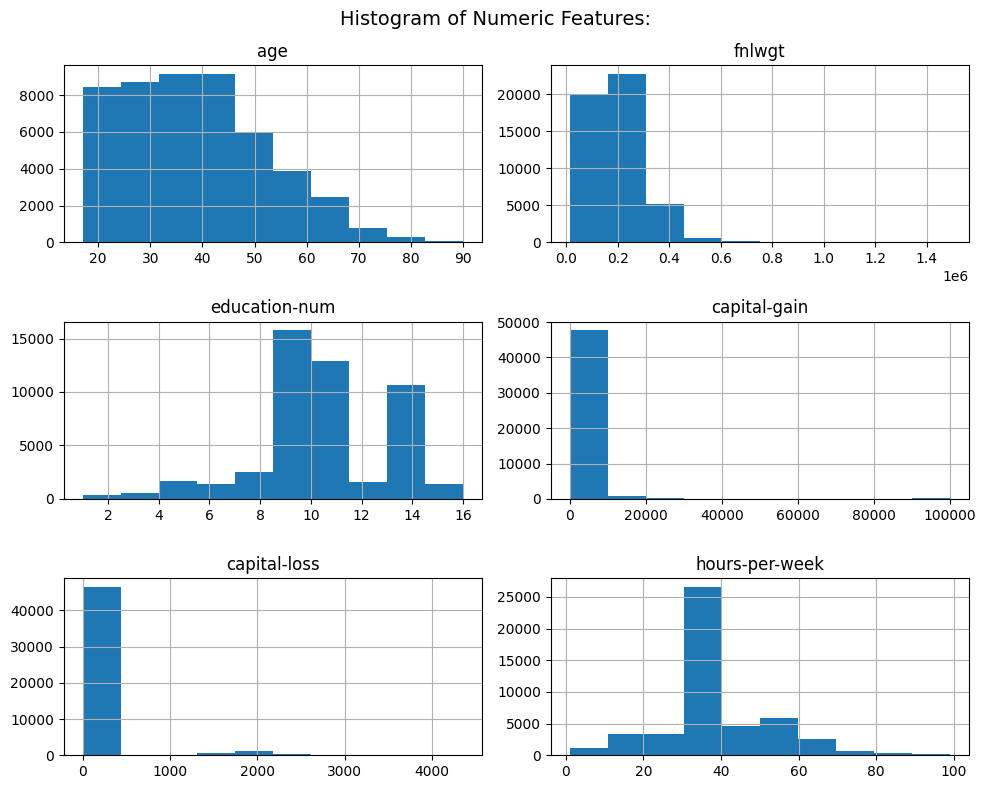

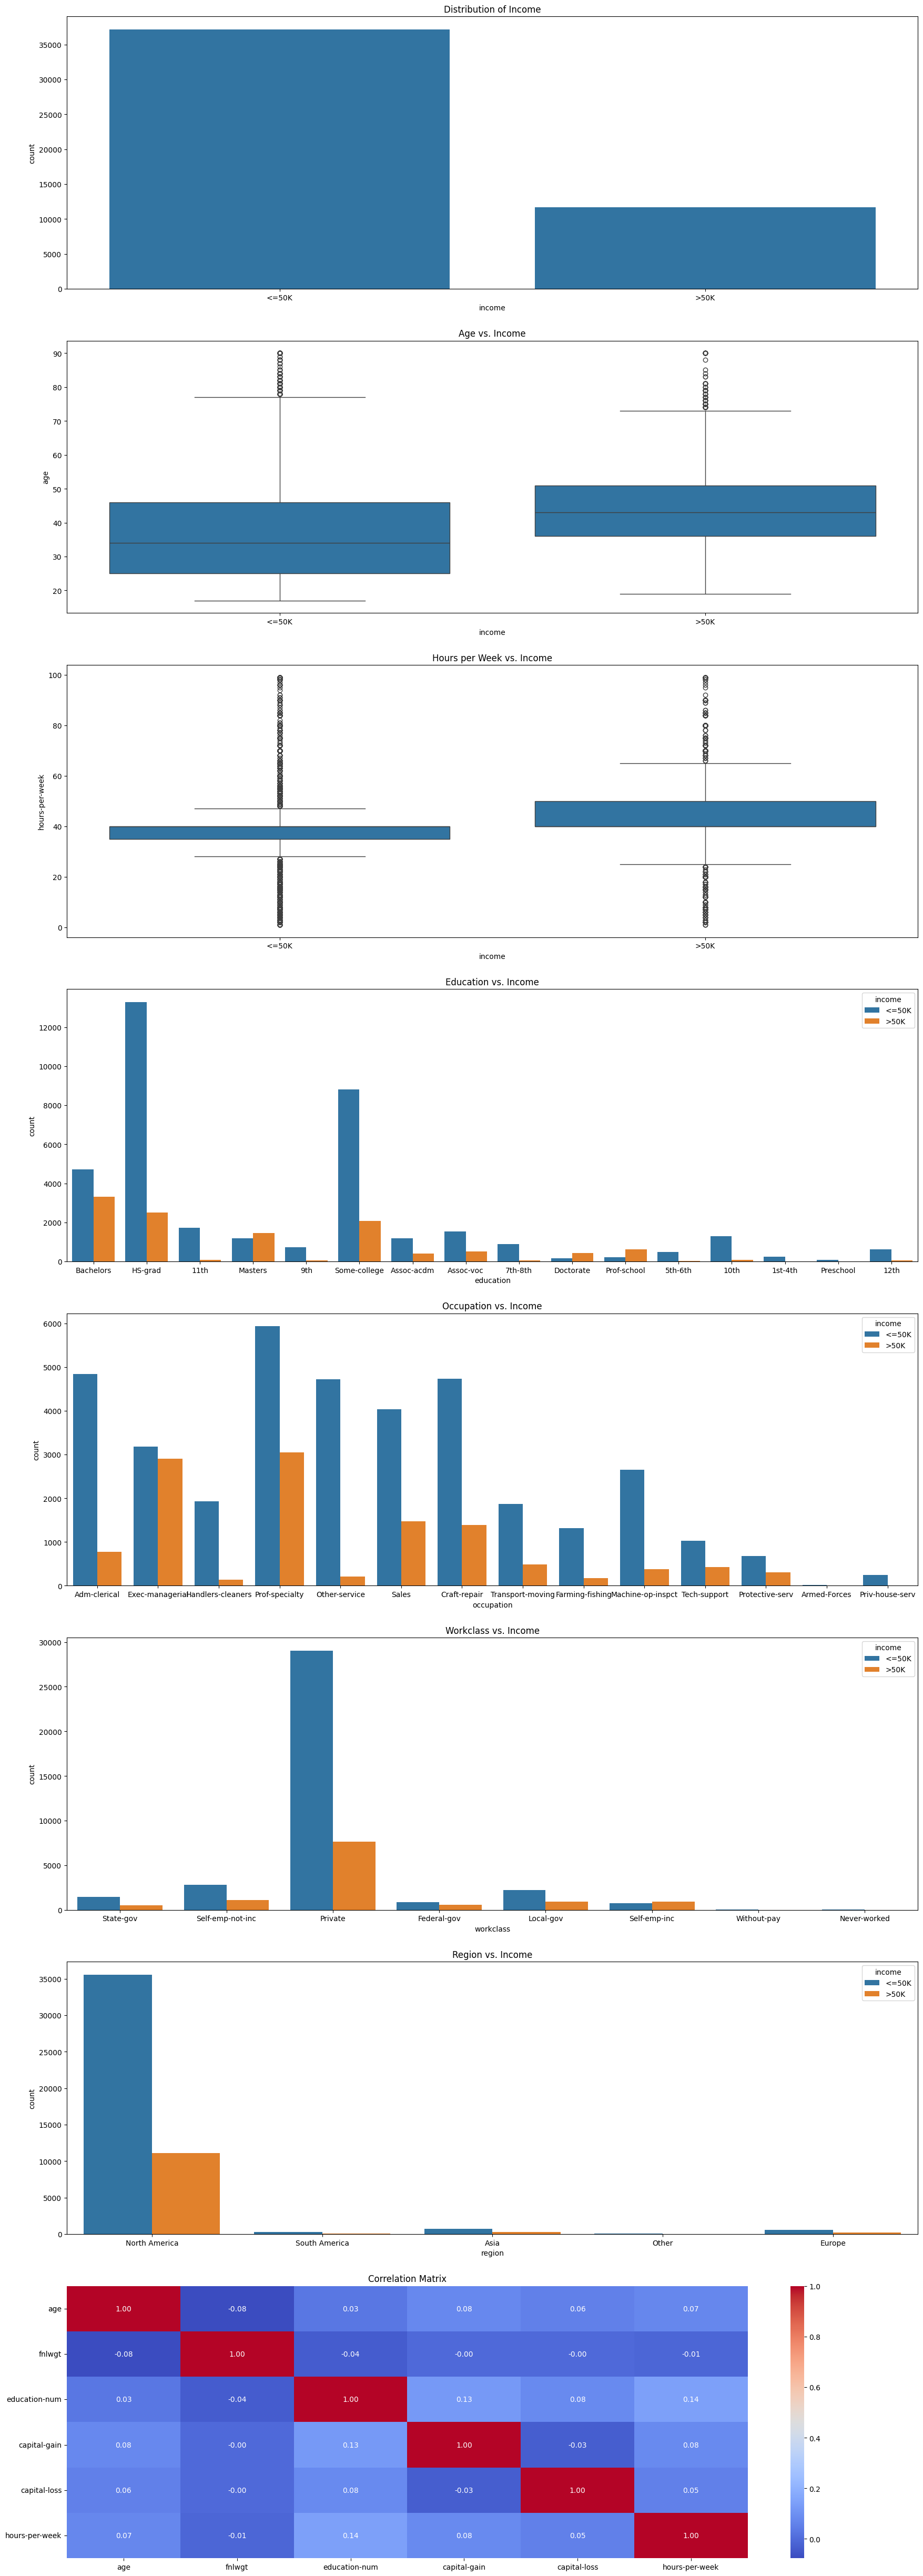

In [45]:
# EDA

print("EDA")

numeric_cols = df.select_dtypes(include=[np.number]).columns
print("\n- Descriptive Statistics (Numeric):")
print(df[numeric_cols].describe().round(3))

if len(numeric_cols) > 0:
  df[numeric_cols].hist(figsize=(10, 8))
  plt.suptitle("Histogram of Numeric Features:", fontsize=14)
  plt.tight_layout()
  plt.show()

print("\n")

# Set up the subplot grid
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(18, 50))  # 8 rows, 1 column
fig.tight_layout(pad=5.0)  # Add padding between subplots

# Plot 1: Distribution of Income
sns.countplot(x='income', data=df, ax=axes[0])
axes[0].set_title('Distribution of Income')

# Plot 2: Age vs. Income
sns.boxplot(x='income', y='age', data=df, ax=axes[1])
axes[1].set_title('Age vs. Income')

# Plot 3: Hours per Week vs. Income
sns.boxplot(x='income', y='hours-per-week', data=df, ax=axes[2])
axes[2].set_title('Hours per Week vs. Income')

# Plot 4: Education vs. Income
sns.countplot(x='education', hue='income', data=df, ax=axes[3])
axes[3].set_title('Education vs. Income')

# Plot 5: Occupation vs. Income
sns.countplot(x='occupation', hue='income', data=df, ax=axes[4])
axes[4].set_title('Occupation vs. Income')

# Plot 6: Workclass vs. Income
sns.countplot(x='workclass', hue='income', data=df, ax=axes[5])
axes[5].set_title('Workclass vs. Income')

# Plot 7: Region vs. Income
sns.countplot(x='region', hue='income', data=df, ax=axes[6])
axes[6].set_title('Region vs. Income')

# Plot 8: Correlation Matrix (Heatmap)
numeric_df = df.select_dtypes(include='number')
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[7])
axes[7].set_title('Correlation Matrix')

# Display the plots
plt.show()

Since we're done with EDA, we will now start on splitting the dataset into **training (60%), validation (20%) and test (20%) sets**.

**Feature engineering** will be next, using OneHotEncoder and StandardScaler to transform the **categorical** and **numerical** columns in these sets.

From the EDA above, we can see that the data is very **imbalanced**, such examples would be the **count of region** (majority from North America) and the **count of workclass** (majority from Private).

To solve this, we will be using:

> **Synthetic Minority Over-sampling Technique (SMOTE)**

SMOTE addresses this issue by **generating synthetic samples** for the minority class, balancing the class distribution and improving the model's ability to learn from the minority class.


In [68]:
# start to encode & scale features then split dataset into train, validation
# and test sets

cat_feats = [
        "workclass", "education", "marital-status",
        "occupation", "relationship", "race",
        "sex", "region"
        ]
num_feats = [
        "age", "fnlwgt", "education-num",
        "capital-gain", "capital-loss", "hours-per-week"
        ]

# Split the dataset into train (60%) and test+val (40%)
train_set, test_val_set = train_test_split(df, test_size=0.4, random_state=42)

# Split the test+val set into validation (20%) and test (20%)
val_set, test_set = train_test_split(test_val_set, test_size=0.5, random_state=42)

# print train, validation and test set shape
print("Train set shape:", train_set.shape)
print("Validation set shape:", val_set.shape)
print("Test set shape:", test_set.shape)

# map income as 0 or 1 based on whether income <= 50k or not
mapping = {"<=50K": 0, ">50K": 1}
train_set["income"] = train_set["income"].map(mapping)
test_set["income"]  = test_set["income"].map(mapping)
val_set["income"] = val_set["income"].map(mapping)

# Split the sets into features (X) and target (y)
X_train = train_set.drop(columns=['income'])  # Features (exclude 'income')
y_train = train_set['income']  # Target (only 'income')

X_val = val_set.drop(columns=['income']) # Features (exclude 'income')
y_val = val_set['income'] # Target (only 'income')

X_test = test_set.drop(columns=['income'])  # Features (exclude 'income')
y_test = test_set['income']  # Target (only 'income')

# Feature Engineering and Scaling
# encoder for categorical, scaler for numerical
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
scaler  = StandardScaler()

# transform categorical and numerical features
X_train_cat = encoder.fit_transform(X_train[cat_feats])
X_train_num = scaler.fit_transform(X_train[num_feats])
X_train = np.concatenate([X_train_cat, X_train_num], axis=1)

X_val_cat = encoder.transform(X_val[cat_feats])
X_val_num = scaler.transform(X_val[num_feats])
X_val = np.concatenate([X_val_cat, X_val_num], axis=1)

X_test_cat = encoder.transform(X_test[cat_feats])
X_test_num = scaler.transform(X_test[num_feats])
X_test = np.concatenate([X_test_cat, X_test_num], axis=1)

'''
Dataset is imbalanced (e.g: region)
Apply SMOTE to handle class imbalance.
SMOTE generates synthetic samples for the minority class
which helps balances the dataset for better model performance
'''
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Print sample distribution
print("\n=== Sample Distribution ===")
print(f"Train (original): {X_train.shape[0]}")
print(f"Train (SMOTE)   : {X_train_sm.shape[0]}")
print(f"Validation      : {X_val.shape[0]}")
print(f"Test            : {X_test.shape[0]}")

Train set shape: (29305, 15)
Validation set shape: (9768, 15)
Test set shape: (9769, 15)

=== Sample Distribution ===
Train (original): 29305
Train (SMOTE)   : 44658
Validation      : 9768
Test            : 9769


Next steps will be:

1.   Tune and train the models.
2.   Evaluate them with classification metrics, confusion matrix, ROC curve and Precision-Recall curve.

In [97]:
'''
This whole section will be functions of tuning and training the models.
'''

# Hyperparameter-Tuned Logistic Regression (Large max_iter)
def train_logistic_regression(X_train, y_train, X_val, y_val):
    """
    Train an LR classifier with hyperparameter tuning using GridSearchCV.

    Parameters:
        X_train: Training features.
        y_train: Training labels.
        X_val: Validation features.
        y_val: Validation labels.

    Returns:
        best_logreg: The best LR model found by GridSearchCV.
    """

    logreg_model = LogisticRegression(random_state=42)

    # insert different hyperparameters into param_grid to pass into GridSearchCV
    param_grid = {
        # Typically, these penalize or strengthen the model's complexity
        'C': [0.01, 0.1, 1],
        'solver': ['lbfgs'],  # restrict to lbfgs (more stable than saga for some cases)
        'max_iter': [2000, 5000]  # large enough to reduce ConvergenceWarning
    }

    grid_search = GridSearchCV(
        logreg_model,
        param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    # use grid search and time how long it takes
    start_time = timer()
    grid_search.fit(X_train, y_train)
    end_time = timer()
    print(f"Grid Search Time: {(end_time - start_time):.3f}s")

    # find the best parameters in params_grid
    best_logreg = grid_search.best_estimator_
    print("\nBest Parameters:", grid_search.best_params_)

    # using best parameters, get validation accuracy of model
    y_val_pred = best_logreg.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy (Best LR): {val_acc:.4f}")

    return best_logreg



# Hyperparameter-Tuned MLP (Bigger max_iter, early_stopping)
def train_mlp_tuned(X_train, y_train, X_val, y_val):
    """
    Train an MLP classifier with hyperparameter tuning using GridSearchCV.

    Parameters:
        X_train: Training features.
        y_train: Training labels.
        X_val: Validation features.
        y_val: Validation labels.

    Returns:
        best_mlp: The best MLP model found by GridSearchCV.
    """

    mlp = MLPClassifier(random_state=42)

    # Large max_iter, plus early_stopping to reduce excessive iteration
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.001, 0.01],
        'learning_rate': ['constant'],
        # Tackle convergence by bigger max_iter & early stopping:
        'max_iter': [600, 1000],
        'early_stopping': [True],
        'n_iter_no_change': [10]  # If no improvement after 10 epochs, stop early
    }

    grid_search = GridSearchCV(
        mlp,
        param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    # use grid search and time how long it takes
    start_time = timer()
    grid_search.fit(X_train, y_train)
    end_time = timer()
    print(f"Grid Search Time: {(end_time - start_time):.3f}s")

    # find the best parameters in params_grid
    best_mlp = grid_search.best_estimator_
    print("\nBest Parameters:", grid_search.best_params_)

    # using best parameters, get validation accuracy of model
    y_val_pred = best_mlp.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy (Best MLP): {val_acc:.4f}")

    return best_mlp



# Hyperparameter-Tuned SVM (Faster)
def train_svm_classifier(X_train, y_train, X_val, y_val):
    """
    Train an SVM classifier with hyperparameter tuning using GridSearchCV.

    Parameters:
        X_train: Training features.
        y_train: Training labels.
        X_val: Validation features.
        y_val: Validation labels.

    Returns:
        best_svm: The best SVM model found by GridSearchCV.
    """
    svm_model = SVC(probability=True, random_state=42)

    # Very narrow param grid to reduce runtime drastically:
    param_grid = {
        'kernel': ['linear', 'rbf'],
        'C': [1],
        'gamma': ['scale'],
        # Limit the number of iterations for speed (may produce warnings if doesn't converge)
        'max_iter': [500, 1000]
    }

    # Fewer folds to reduce run time
    grid_search = GridSearchCV(
        svm_model,
        param_grid,
        cv=2,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    # use grid search and time how long it takes
    start_time = timer()
    grid_search.fit(X_train, y_train)
    end_time = timer()
    print(f"Grid Search Time: {(end_time - start_time):.3f}s")

    # find the best parameters in params_grid
    best_svm = grid_search.best_estimator_
    print("\nBest Parameters:", grid_search.best_params_)

    # using best parameters, get validation accuracy of model
    y_val_pred = best_svm.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy (Best SVM): {val_acc:.4f}")

    return best_svm

In [91]:
# Method to evaluate all classification models

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the performance of a trained model on the test set.

    Parameters:
        model: The trained machine learning model.
        X_test: Test features.
        y_test: True labels for the test set.
    """
    # Start timer to measure prediction time
    start_time = timer()

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # End timer and calculate total prediction time
    end_time = timer()
    total_time = end_time - start_time

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec  = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1   = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Check if the model supports probability estimates or decision function
    has_proba    = hasattr(model, "predict_proba")
    has_decision = hasattr(model, "decision_function")

    # Initialize variables for ROC-AUC and predicted probabilities
    roc_auc = None
    y_prob  = None

    # If the model supports probability estimates, use predict_proba
    if has_proba:
        y_prob = model.predict_proba(X_test)[:, 1]  # Predicted probabilities for the positive class
        roc_auc = roc_auc_score(y_test, y_prob)  # Calculate ROC-AUC score

    # If the model supports decision function but not predict_proba, use decision_function
    elif has_decision:
        decision_vals = model.decision_function(X_test)  # Decision function values
        dv_min, dv_max = decision_vals.min(), decision_vals.max()  # Min and max values
        y_prob = (decision_vals - dv_min) / (dv_max - dv_min + 1e-9)  # Normalize to [0, 1]
        roc_auc = roc_auc_score(y_test, y_prob)  # Calculate ROC-AUC score

    # Print evaluation metrics
    print("\n=== Model Evaluation ===")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC  : {roc_auc:.4f}")  # ROC-AUC (if available)

    # Print total prediction time and average time per sample
    print(f"Prediction Time (total): {total_time:.6f}s")
    print(f"Avg Time per Sample    : {total_time/len(X_test):.6f}s")

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=["<=50K", ">50K"])
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # If predicted probabilities are available, plot ROC and Precision-Recall curves
    if y_prob is not None:
        # Compute ROC curve and Precision-Recall curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)  # ROC curve
        prec_vals, rec_vals, _ = precision_recall_curve(y_test, y_prob)  # Precision-Recall curve

        # Create a figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

        # Plot ROC Curve on the first subplot
        ax1.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
        ax1.set_title("ROC Curve")
        ax1.set_xlabel("False Positive Rate")
        ax1.set_ylabel("True Positive Rate")
        ax1.legend()

        # Plot Precision-Recall Curve on the second subplot
        ax2.plot(rec_vals, prec_vals)
        ax2.set_title("Precision-Recall Curve")
        ax2.set_xlabel("Recall")
        ax2.set_ylabel("Precision")

        # Adjust layout for better spacing
        plt.tight_layout()

        # Show the plots
        plt.show()

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Grid Search Time: 5.696s

Best Parameters: {'C': 1, 'max_iter': 2000, 'solver': 'lbfgs'}
Validation Accuracy (Best LR): 0.8100

=== LOGISTIC REGRESSION ===

=== Model Evaluation ===
Accuracy : 0.8024
Precision: 0.8511
Recall   : 0.8024
F1 Score : 0.8144
ROC-AUC  : 0.9051
Prediction Time (total): 0.001947s
Avg Time per Sample    : 0.000000s


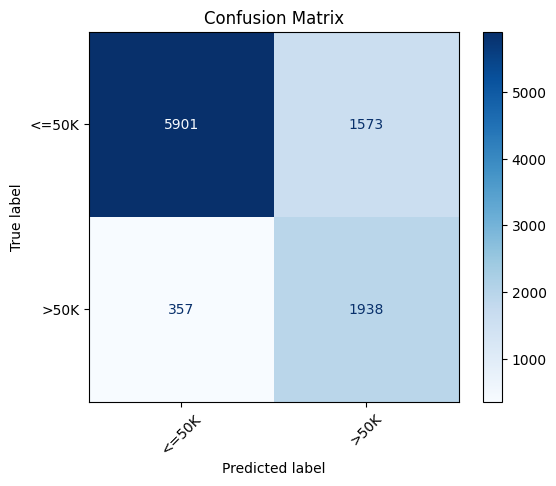


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      7474
           1       0.55      0.84      0.67      2295

    accuracy                           0.80      9769
   macro avg       0.75      0.82      0.76      9769
weighted avg       0.85      0.80      0.81      9769



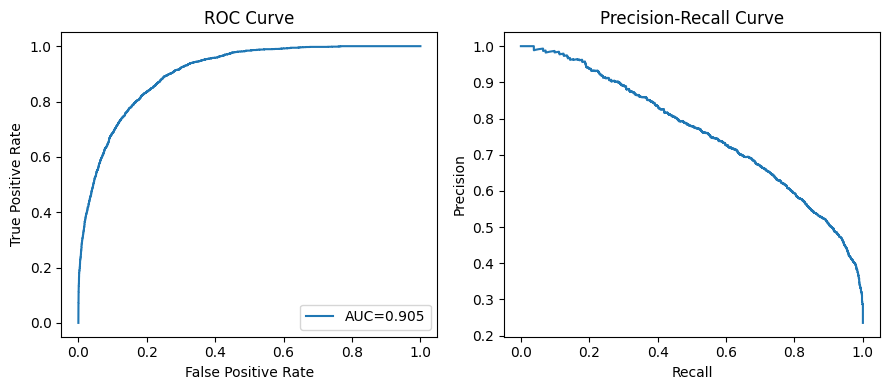


=== DONE ===


In [92]:
# Evaluate tuned LR model
best_logreg = train_logistic_regression(X_train_sm, y_train_sm, X_val, y_val)
print("\n=== LOGISTIC REGRESSION ===")
evaluate_model(best_logreg, X_test, y_test)
print("\n=== DONE ===")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Grid Search Time: 409.814s

Best Parameters: {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 600, 'n_iter_no_change': 10}
Validation Accuracy (Best MLP): 0.8133

=== MULTILAYER PERCEPTRON ===

=== Model Evaluation ===
Accuracy : 0.8188
Precision: 0.8509
Recall   : 0.8188
F1 Score : 0.8278
ROC-AUC  : 0.9014
Prediction Time (total): 0.014998s
Avg Time per Sample    : 0.000002s


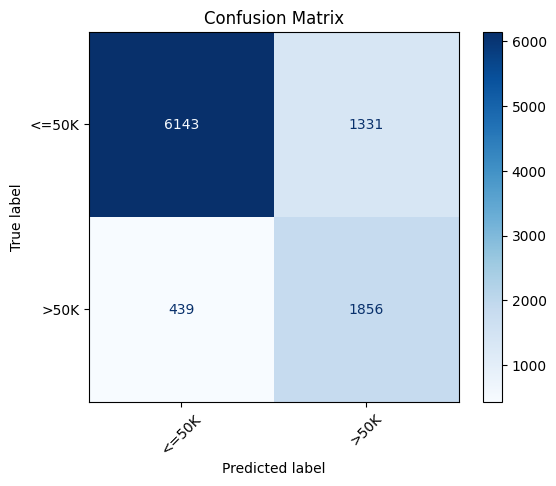


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      7474
           1       0.58      0.81      0.68      2295

    accuracy                           0.82      9769
   macro avg       0.76      0.82      0.78      9769
weighted avg       0.85      0.82      0.83      9769



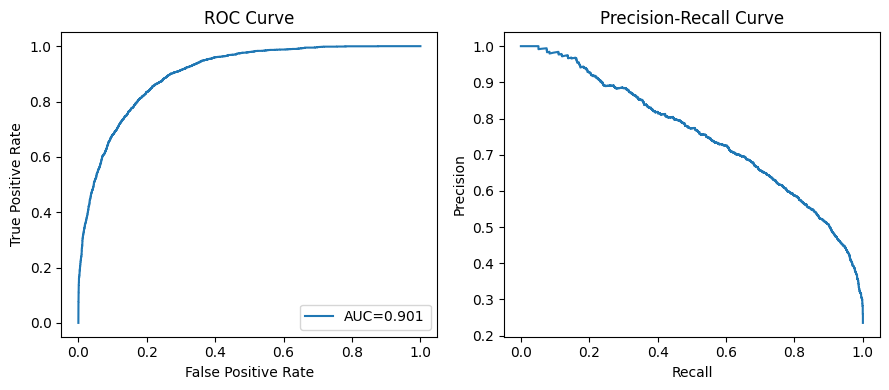


=== DONE ===


In [94]:
# Evaluate tuned MLP model
best_mlp = train_mlp_tuned(X_train_sm, y_train_sm, X_val, y_val)
print("\n=== MULTILAYER PERCEPTRON ===")
evaluate_model(best_mlp, X_test, y_test)
print("\n=== DONE ===")

Fitting 2 folds for each of 4 candidates, totalling 8 fits


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Grid Search Time: 176.057s

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': 500}
Validation Accuracy (Best SVM): 0.4889

=== SVM ===

=== Model Evaluation ===
Accuracy : 0.4854
Precision: 0.7284
Recall   : 0.4854
F1 Score : 0.5093
ROC-AUC  : 0.6642
Prediction Time (total): 0.237206s
Avg Time per Sample    : 0.000024s


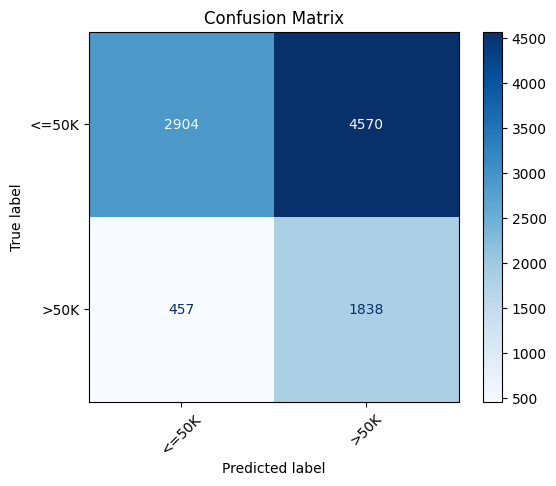


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.39      0.54      7474
           1       0.29      0.80      0.42      2295

    accuracy                           0.49      9769
   macro avg       0.58      0.59      0.48      9769
weighted avg       0.73      0.49      0.51      9769



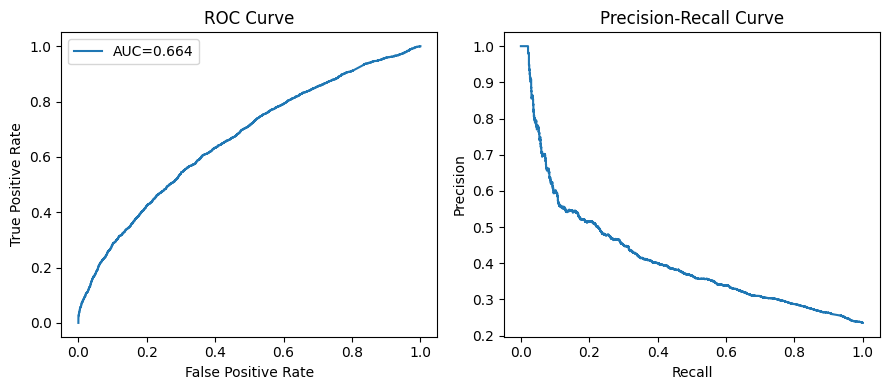

=== DONE ===


In [96]:
# Evaluate tuned SVM model
best_svm_model = train_svm_classifier(X_train_sm, y_train_sm, X_val, y_val)
print("\n=== SVM ===")
evaluate_model(best_svm_model, X_test, y_test)
print("=== DONE ===")

From the three tuned models, their evaluations are:

> LOGISTIC REGRESSION

Accuracy : 0.8024

Precision: 0.8511

Recall   : 0.8024

F1 Score : 0.8144

ROC-AUC  : 0.9051

Prediction Time (total): 0.001947s

Avg Time per Sample    : 0.000000s

---

> MULTILAYER PERCEPTRON

Accuracy : 0.8188

Precision: 0.8509

Recall   : 0.8188

F1 Score : 0.8278

ROC-AUC  : 0.9014

Prediction Time (total): 0.014998s

Avg Time per Sample    : 0.000002s

---

> SVM

Accuracy : 0.4854

Precision: 0.7284

Recall   : 0.4854

F1 Score : 0.5093

ROC-AUC  : 0.6642

Prediction Time (total): 0.249619s

Avg Time per Sample    : 0.000026s

---

Comparing the accuracy of all models,

MLP performed the best, followed by LR, then SVM.

The best model would be MLP.



